In [1]:
import pyocr
import pyocr.builders
tool = pyocr.get_available_tools()[0]
from PIL import Image
import cv2
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
img = cv2.imread('test.png')
gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) # convert to grayscale
gray_img = cv2.GaussianBlur(gray_img,(3,3),0) # denoise image
gray_img = Image.fromarray(gray_img)

In [18]:
W,H = gray_img.size # (2454, 3600)
RED, GREEN, BLUE = (255,0,0), (0,255,0), (0,0,255)

In [3]:
wordboxes = tool.image_to_string(
    gray_img,
    lang='deu+fra',
    builder=pyocr.builders.WordBoxBuilder())

In [4]:
lineboxes = tool.image_to_string(
    gray_img,
    lang='deu+fra',
    builder=pyocr.builders.LineBoxBuilder() )

In [19]:
def draw_boxes(boxes, color=RED, thickness=2, img=img, fontscale=1, filename=None, show=False):
    _img = img.copy()
    for i,lnbox in enumerate(boxes): 
        p1,p2 = lnbox.position
        cv2.rectangle(_img, p1, p2, color, thickness)
        cv2.putText(_img, str(i), p1, cv2.FONT_HERSHEY_DUPLEX, fontscale, color, thickness)
    if filename != None:
        '''cvtColor to make saved cv2 and matplotlib conform, 
        see: http://www.pyimagesearch.com/2014/11/03/display-matplotlib-rgb-image/'''
        cv2.imwrite(filename, cv2.cvtColor(_img, cv2.COLOR_RGB2BGR) )
    if show:
        plt.figure(figsize=(15,30))
        plt.imshow(_img)
    return _img

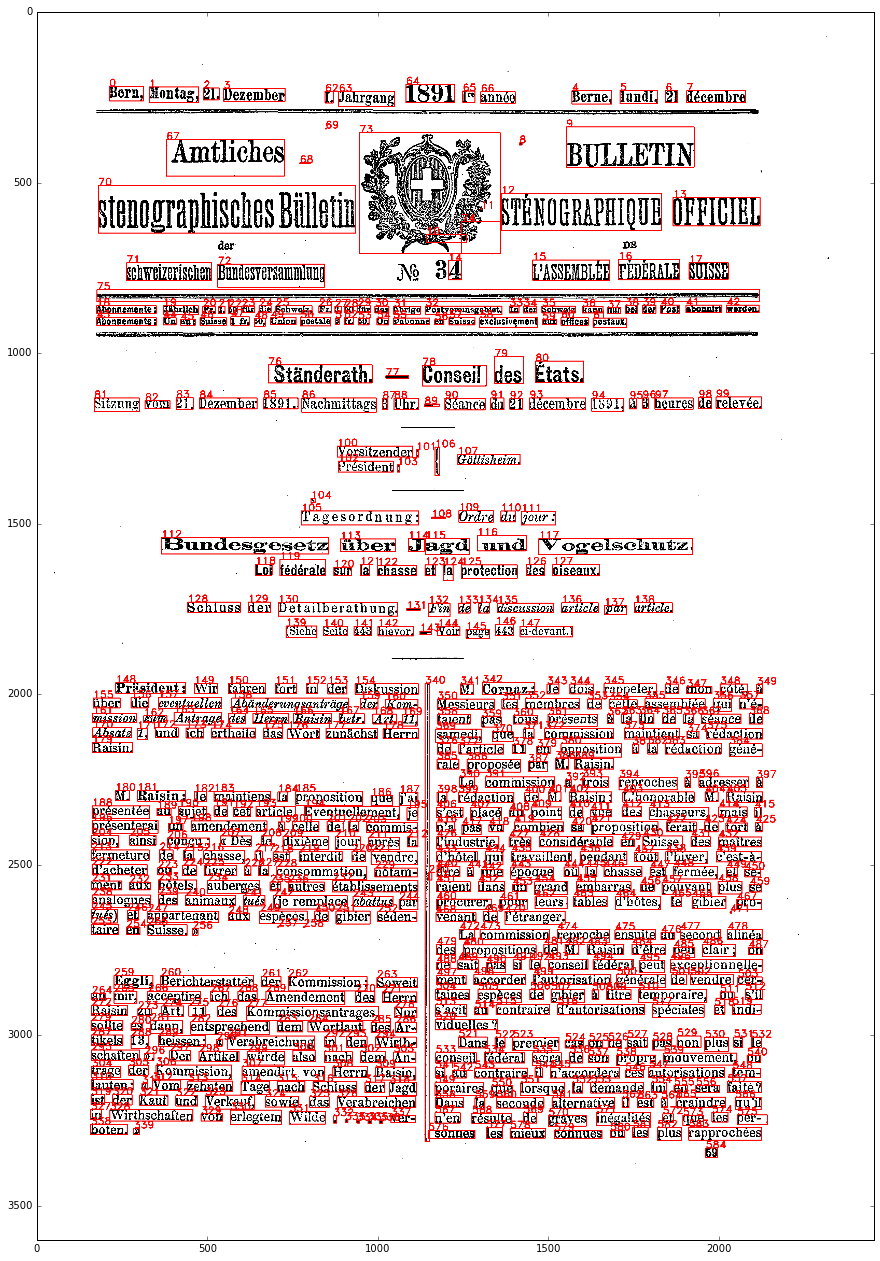

In [12]:
_img = draw_boxes(wordboxes, filename='wordboxes.jpg', thickness=2, fontscale=1, show=True)

In [20]:
for idx in [8, 69,73,75,104,111]:
    print idx, '\t', wordboxes[idx].content.strip()

8 	'
69 	’
73 	
75 	
104 	\
111 	jour:


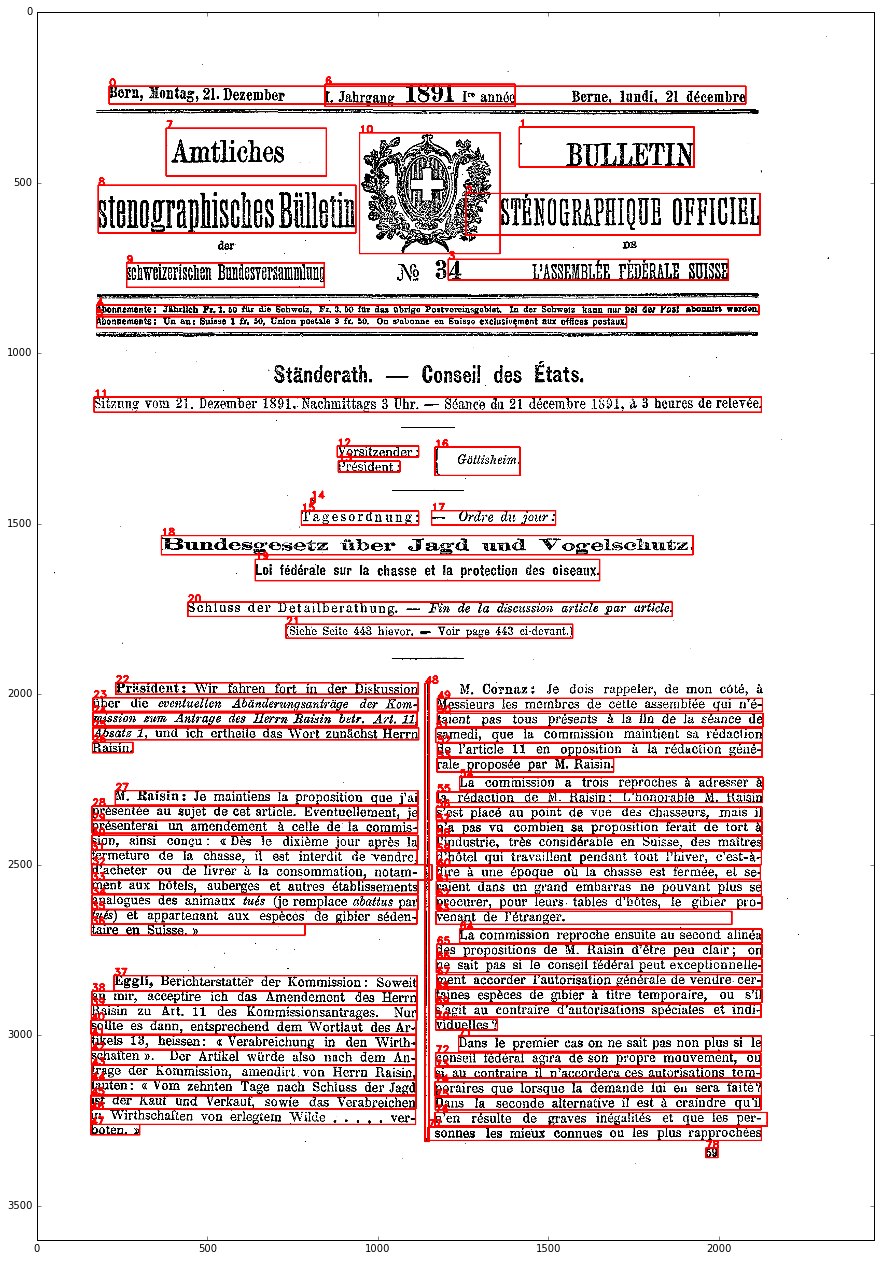

In [15]:
_img = draw_boxes(lineboxes, filename='lineboxes.jpg', thickness=3, fontscale=1, show=True)

In [17]:
for idx in [0,4,6,8,49]:
    print idx, '\t', lineboxes[idx].content

0 	Bern, Montag, 21. Dezember Berne, lundi. 21 décembre
4 	Abonnemente: “much Fr. 1. so fu: die Schweiz. Fr. 3. 50 fur du ubriga Po-tvereinsgebtot. In der Schweiz kann nur bal du Fos! about:: werden.
6 	I. Jahrgang 1891 I" année
8 	stanngrapiisniesBülliii
49 	Messieurs les membres de cette assemblée qui n’é-


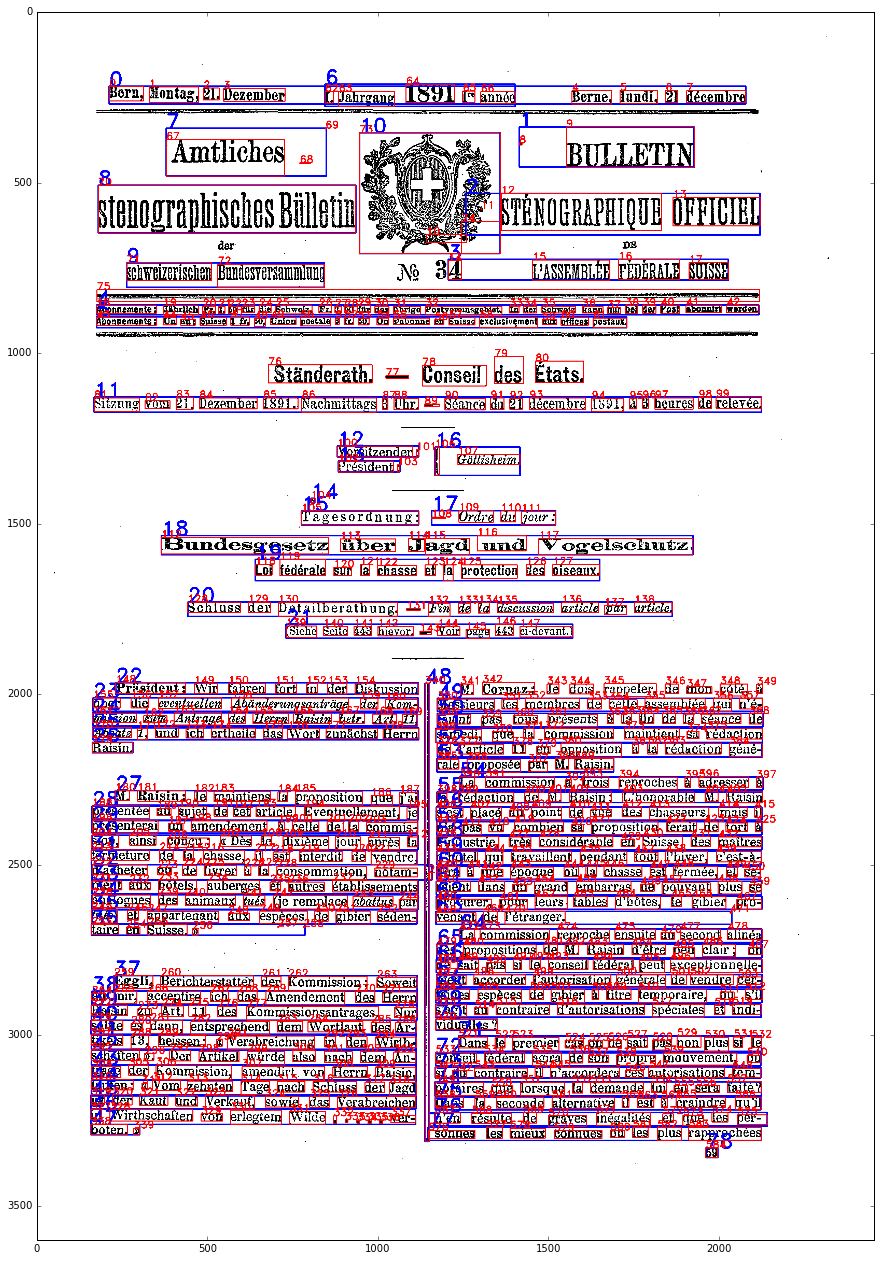

In [21]:
_img = draw_boxes(lineboxes, color=BLUE, thickness=3, fontscale=2, show=False)
_img = draw_boxes(wordboxes, img=_img, filename='word_line_boxes.jpg', thickness=2, fontscale=1, show=True)

# Finding paragraph boxes

## Define helper function and ParagraphBox class

In [22]:
def overlap(rect1, rect2, vmargin=15, hmargin=15):
    'testing if 2 rectangles overlap (up to a V/H margin)'
    (l1,b1),(r1,t1) = rect1
    assert l1<=r1 and b1<=t1 
    (l2,b2),(r2,t2) = rect2
    assert l2<=r2 and b2<=t2 
    if r1+hmargin<l2 or r2+hmargin<l1: return False
    if t1+vmargin<b2 or t2+vmargin<b1: return False
    return True

# overlap(((230, 1967), (1116, 2001)), ((164, 2011), (1115, 2051)))

In [23]:
class ParagraphBox(object):
    def __init__(self, boxes, box_indices = None): # here the boxes could be wordboxes OR lineboxes
        self._boxes = boxes
        self.box_indices = box_indices # add this for debugging, should be removed afterwards...
        _rects = [box.position for box in self._boxes]
        l = min(rect[0][0] for rect in _rects)
        b = min(rect[0][1] for rect in _rects)
        r = max(rect[1][0] for rect in _rects)
        t = max(rect[1][1] for rect in _rects)
        self.position =  ((l,b), (r,t))
        
    def __get_content(self):
        txt = u' '.join([_box.content for _box in self._boxes])
        return txt
    content = property(__get_content)

## Merging lineboxes into paraboxes

In [42]:
def get_paraboxes(boxes, mode='last', vmargin=15, hmargin=15, show=False, verbose=False, **kwargs):
    '''
    merging boxes to form paragraph boxes, 
    supposes boxes are well ordered (the output of pyocr is already quite well-ordered). 
    
    there are 2 modes to choose: 
    * 'last': stops growing paragraph when current box doesn't overlap with last box in buffer
    * 'any': stops growiing when current box doesn't overlap with any box in buffer
    '''
    paraboxes = [] # list of ParagraphBox objs
    buffer_indices = [] # list of wdbox/lnbox indices as buffer

    def add_para():
        _boxes = [boxes[k] for k in buffer_indices]
        parabox = ParagraphBox(_boxes, buffer_indices)
        if verbose:
            print '-----found para-----', len(paraboxes)
            print parabox.box_indices
            print parabox.content
        paraboxes.append(parabox)


    for i,box in enumerate(boxes):
        ctt = box.content.strip()
        if len(ctt) == 0: 
            continue # skip too short contents --> these are probably errors
            
#         if len(ctt)==1 and not(ctt.isalpha() or ctt.isdigit()): 
#             continue

        if len(buffer_indices)==0:
            buffer_indices.append(i)
            continue

        cur_rect = box.position

        if mode=='last':
            stop_flag = overlap(cur_rect, boxes[buffer_indices[-1]].position, vmargin, hmargin)
        elif mode=='any':
            _rects = [boxes[k].position for k in buffer_indices] # all rects in (partial) paragraph
            stop_flag = any( overlap(rect, cur_rect, vmargin, hmargin) for rect in _rects )
        else:
            raise Error("invalid mode: %s, possible choices are: 'last', 'any'. " % mode)
        if stop_flag:
            buffer_indices.append(i)
        else: 
            add_para()
            buffer_indices = [i]
    add_para()
    
    if show:
        _img = draw_boxes(paraboxes,color=BLUE, thickness=5, fontscale=2)
        _img = draw_boxes(boxes, img=_img, color=RED, thickness=2, fontscale=1,**kwargs)
        plt.figure(figsize=(15,30))
        plt.imshow(_img)
        
    return paraboxes

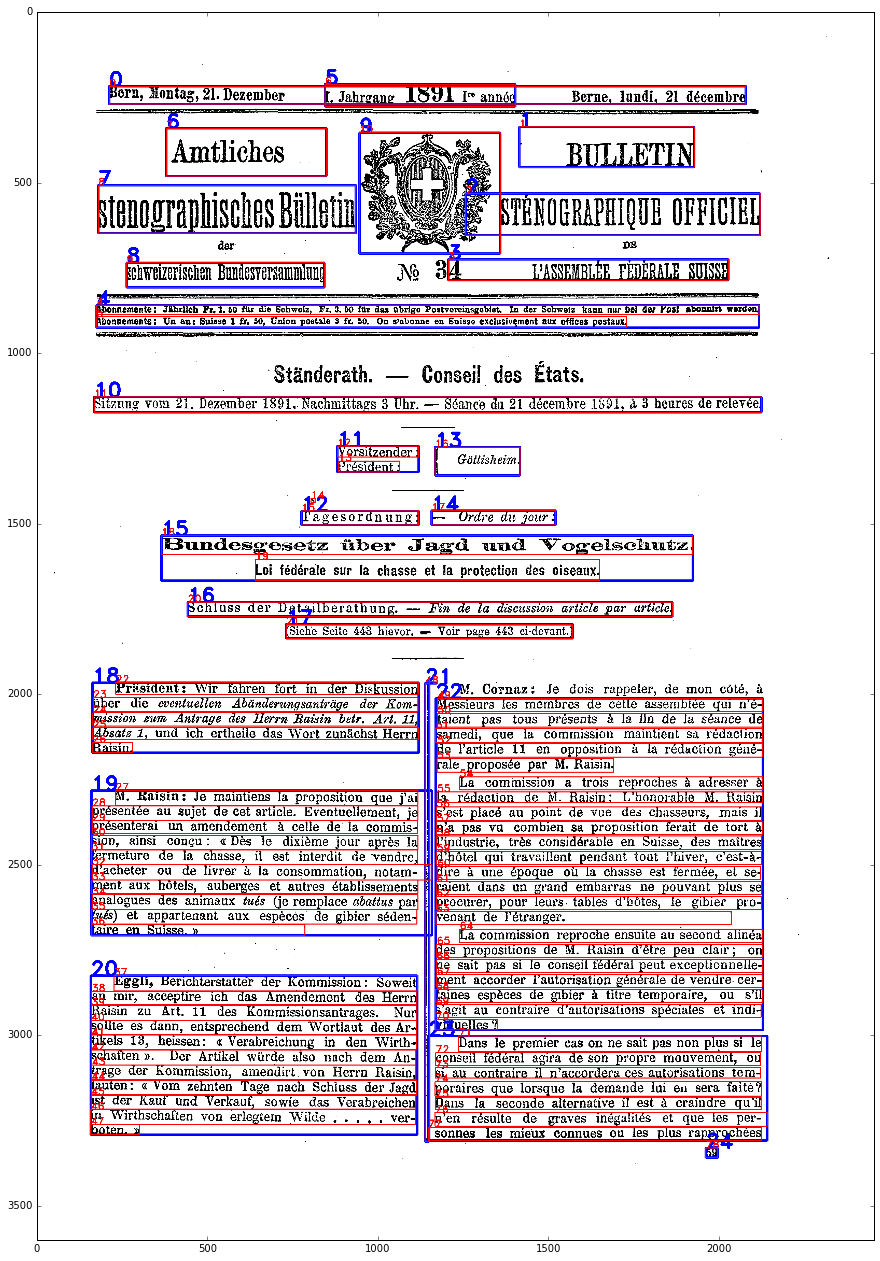

In [36]:
paraboxes = get_paraboxes(lineboxes, filename='line_to_para.jpg', show=True)

## Merging wordboxes into paraboxes

When merging wordboxes into paraboxes, need to use 'any' mode, otherwise can't handle line changing.

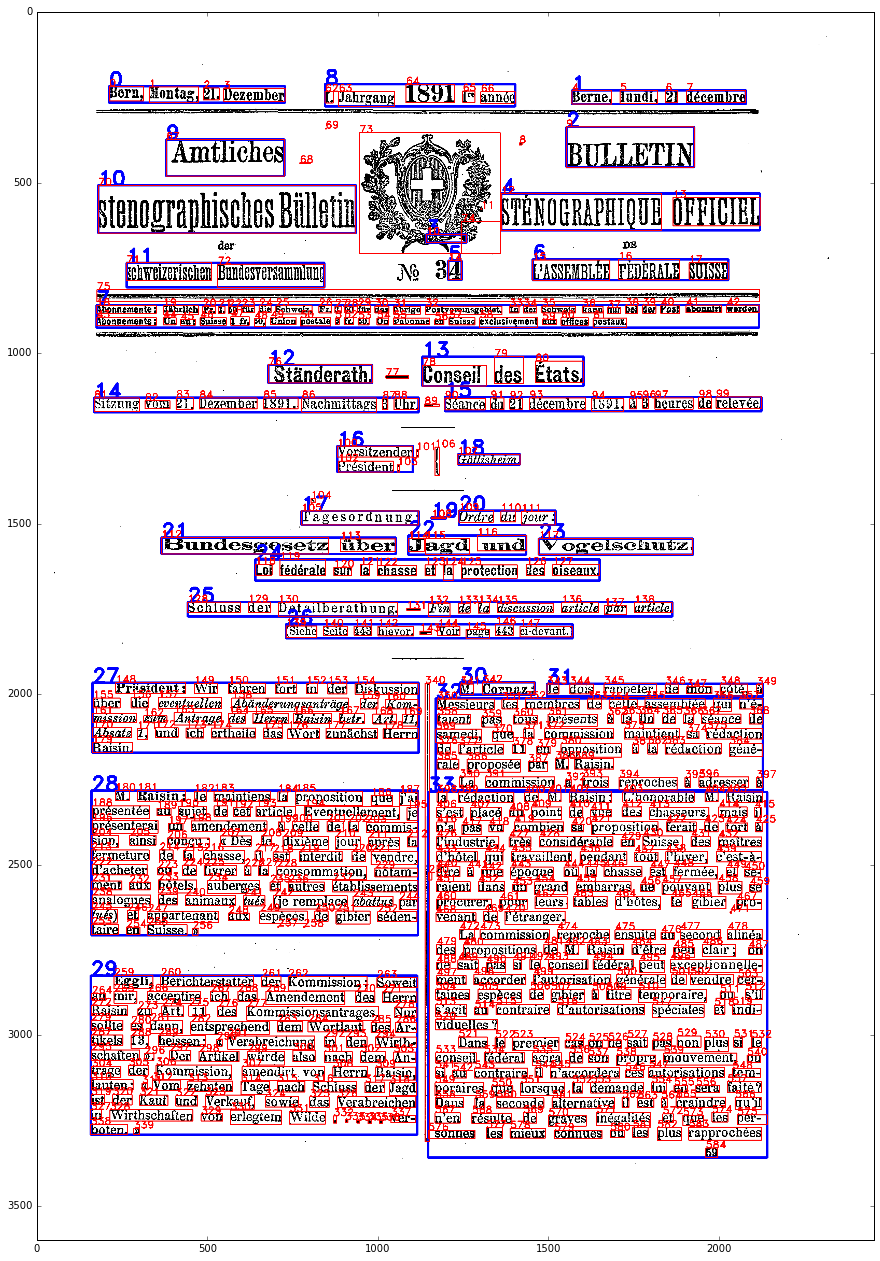

In [37]:
paraboxes = get_paraboxes(wordboxes, mode='any', vmargin=25, hmargin=35, filename='word_to_para.jpg', show=True)

## Merging wordboxes into lines, then merge lines into paragraphs -- gives best result

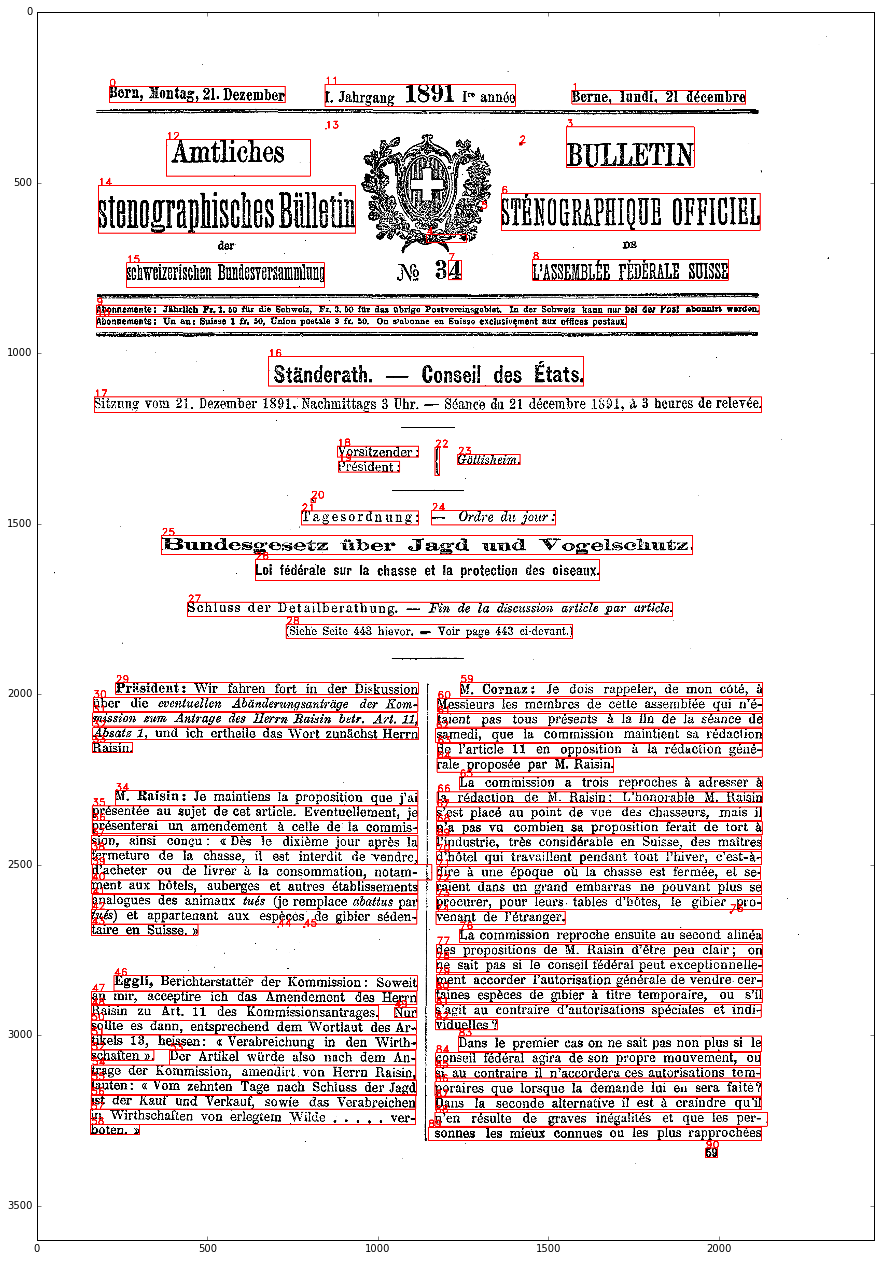

In [54]:
my_lineboxes = get_paraboxes(wordboxes, mode='last', hmargin=45,)
_img = draw_boxes(my_lineboxes, show=True, filename='my_lineboxes.jpg')

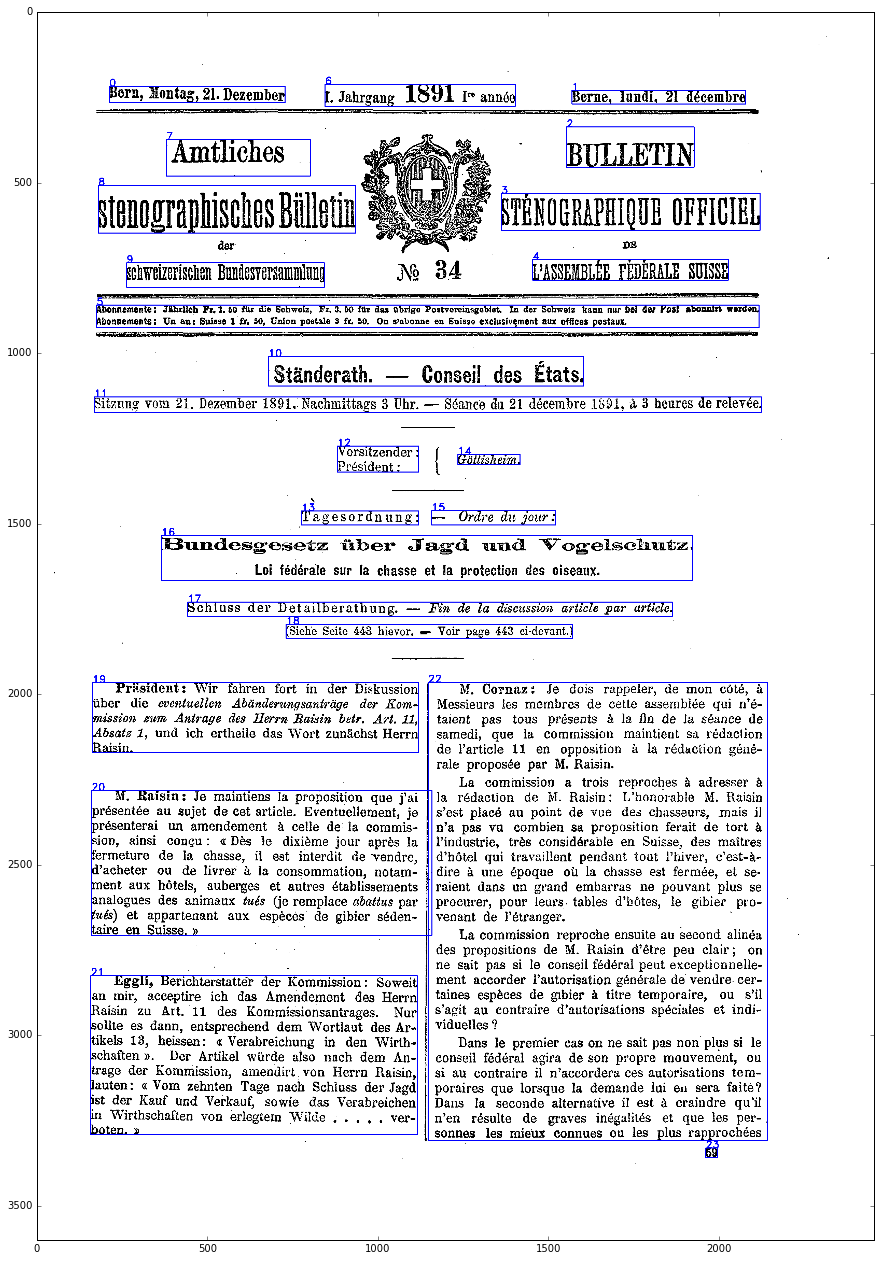

In [55]:
paraboxes = get_paraboxes(my_lineboxes, mode='any', vmargin=20)
# filter out paragraph boxes with content length<=1
paraboxes = filter(lambda bx: len(bx.content)>1, paraboxes)
_img = draw_boxes(paraboxes, show=True, color=BLUE, filename='paraboxes.jpg')

In [61]:
names = []
text = []
for pbox in paraboxes:
    txt = pbox.content
    text.append(txt)
    if len(txt)>200 and ':' in txt[:100]:
        names.append(txt.split(':')[0])
#     print '------------'
#     print txt

print '================='
print 'participant names are:'
for nm in names: print nm

participant names are:
Abonnemente
Präsident
M. Raisin
Eggli, Berichterstatter der Kommission
M. Cornnz


In [ ]:
names = []
for 